# Tutorial: Yeast TYE7 bulk calling cards data

In this data, we test transcription factor TYE7 bindings in yeast by single-cell(sc) calling cards techenology. The data is from [Shively CA, PNAS. (2020)](https://www.pnas.org/doi/10.1073/pnas.1818015116?url_ver=Z39.88-2003&rfr_id=ori:rid:crossref.org&rfr_dat=cr_pub%20%200pubmed) and could be download from [GEO](https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE134427).

In this tutorial, we will call peaks, make annotation and do differential peak analysis. 

In [1]:
import pycallingcards as cc
import numpy as np
import pandas as pd
import scanpy as sc

We start by reading qbed data. Because this data is published several years ago, the data is in the old format: one row is one insertion and columns indecate the chromosome, start point and read number. Here, We transfer it to the new version.

You could use ```cc.rd.read_qbed(filename)``` to read your own qbed data.

In [2]:
TYE7 = cc.rd.read_qbed("https://github.com/The-Mitra-Lab/pycallingcards_data/releases/download/data/GSM3946397_TEF1p_TYE7_ALL.gnashy.txt")
TYE7

,Chr,Start,End,Reads,Direction,Barcodes
0,1,1501,111,NaN,NaN,NaN
1,1,1502,1,NaN,NaN,NaN
2,1,5320,1,NaN,NaN,NaN
3,1,5544,199,NaN,NaN,NaN
4,1,32962,1,NaN,NaN,NaN
...,...,...,...,...,...,...
11450,16,928369,1,NaN,NaN,NaN
11451,16,928381,14,NaN,NaN,NaN
11452,16,928555,34,NaN,NaN,NaN
11453,16,930647,330,NaN,NaN,NaN


In [3]:
TYE7_gcr2ko = cc.rd.read_qbed("https://github.com/The-Mitra-Lab/pycallingcards_data/releases/download/data/GSM3946398_TEF1p_TYE7_gcr2ko_ALL.gnashy.txt")
TYE7_gcr2ko

,Chr,Start,End,Reads,Direction,Barcodes
0,1,3108,1,NaN,NaN,NaN
1,1,8064,9,NaN,NaN,NaN
2,1,30957,2,NaN,NaN,NaN
3,1,30989,1,NaN,NaN,NaN
4,1,31530,1,NaN,NaN,NaN
...,...,...,...,...,...,...
12283,16,930468,2,NaN,NaN,NaN
12284,16,930698,13,NaN,NaN,NaN
12285,16,936191,4,NaN,NaN,NaN
12286,16,938479,3,NaN,NaN,NaN


Define a function to transfer data to new version.

In [4]:
def transfer(data):
    for i in range(len(data)):
        data.iloc[i,3] = data.iloc[i,2]
        data.iloc[i,2] = data.iloc[i,1] + 1
        num = data.iloc[i,0]
        if num == 1:
            data.iloc[i,0] = 'chrI'
        elif num == 2:
            data.iloc[i,0] = 'chrII'
        elif num == 3:
            data.iloc[i,0] = 'chrIII'
        elif num == 4:
            data.iloc[i,0] = 'chrIV'
        elif num == 5:
            data.iloc[i,0] = 'chrV'
        elif num == 6:
            data.iloc[i,0] = 'chrVI'
        elif num == 7:
            data.iloc[i,0] = 'chrVII'
        elif num == 8:
            data.iloc[i,0] = 'chrVIII'
        elif num == 9:
            data.iloc[i,0] = 'chrIX'  
        elif num == 10:
            data.iloc[i,0] = 'chrX'
        elif num == 11:
            data.iloc[i,0] = 'chrXI'
        elif num == 12:
            data.iloc[i,0] = 'chrXII'
        elif num == 13:
            data.iloc[i,0] = 'chrXIII'
        elif num == 14:
            data.iloc[i,0] = 'chrXIV'
        elif num == 15:
            data.iloc[i,0] = 'chrXV'
        elif num == 16:
            data.iloc[i,0] = 'chrXVI'
    return data

In [5]:
TYE7 = transfer(TYE7)
TYE7['group'] = 'TYE7'
TYE7

,Chr,Start,End,Reads,Direction,Barcodes,group
0,chrI,1501,1502,111.0,NaN,NaN,TYE7
1,chrI,1502,1503,1.0,NaN,NaN,TYE7
2,chrI,5320,5321,1.0,NaN,NaN,TYE7
3,chrI,5544,5545,199.0,NaN,NaN,TYE7
4,chrI,32962,32963,1.0,NaN,NaN,TYE7
...,...,...,...,...,...,...,...
11450,chrXVI,928369,928370,1.0,NaN,NaN,TYE7
11451,chrXVI,928381,928382,14.0,NaN,NaN,TYE7
11452,chrXVI,928555,928556,34.0,NaN,NaN,TYE7
11453,chrXVI,930647,930648,330.0,NaN,NaN,TYE7


In [6]:
TYE7_gcr2ko = transfer(TYE7_gcr2ko)
TYE7_gcr2ko['group'] = 'TYE7_gcr2ko'
TYE7_gcr2ko

,Chr,Start,End,Reads,Direction,Barcodes,group
0,chrI,3108,3109,1.0,NaN,NaN,TYE7_gcr2ko
1,chrI,8064,8065,9.0,NaN,NaN,TYE7_gcr2ko
2,chrI,30957,30958,2.0,NaN,NaN,TYE7_gcr2ko
3,chrI,30989,30990,1.0,NaN,NaN,TYE7_gcr2ko
4,chrI,31530,31531,1.0,NaN,NaN,TYE7_gcr2ko
...,...,...,...,...,...,...,...
12283,chrXVI,930468,930469,2.0,NaN,NaN,TYE7_gcr2ko
12284,chrXVI,930698,930699,13.0,NaN,NaN,TYE7_gcr2ko
12285,chrXVI,936191,936192,4.0,NaN,NaN,TYE7_gcr2ko
12286,chrXVI,938479,938480,3.0,NaN,NaN,TYE7_gcr2ko


In order to call peak, we need to conbine two qbed files together.

In [7]:
qbed_data = cc.rd.combine_qbed([TYE7,TYE7_gcr2ko])
qbed_data

,Chr,Start,End,Reads,Direction,Barcodes,group
0,chrI,1501,1502,111.0,NaN,NaN,TYE7
1,chrI,1502,1503,1.0,NaN,NaN,TYE7
2,chrI,1557,1558,304.0,NaN,NaN,TYE7_gcr2ko
3,chrI,1687,1688,8.0,NaN,NaN,TYE7_gcr2ko
4,chrI,1690,1691,7.0,NaN,NaN,TYE7_gcr2ko
...,...,...,...,...,...,...,...
23738,chrXVI,939075,939076,120.0,NaN,NaN,TYE7_gcr2ko
23739,chrXVI,939536,939537,22.0,NaN,NaN,TYE7
23740,chrXVI,940225,940226,1.0,NaN,NaN,TYE7_gcr2ko
23741,chrXVI,941830,941831,116.0,NaN,NaN,TYE7_gcr2ko


As insertions are discrete, we now call peaks to deduce potential binding sites. Three different methods (*CCcaller,cc_tools,Blockify*) are available along with there different species (*hg38,mm10,sacCer3*). 

Because of the particularity of yeast calling cards data, we use ***cc_tools*** in *yeast*('sacCer3') data. *window_size* is the most important parameter for *cc_tools*, it is highly related to the length of a peak. 100-200 is a good fit for *window_size*. *step_size* is another important paramenter and it controls how careful we are looking into the chromosomes. 30-100 is good for *step_size*.*pvalue_cutoff* is also important parameters and the numbers below 0.1 is strongly advised.

In [8]:
peak_data = cc.pp.callpeaks(qbed_data, method = "cc_tools", reference = "sacCer3", extend = 50, window_size = 125, step_size = 60,
                  pvalue_cutoff = 0.1,   lam_win_size = None,  pseudocounts = 0, record = True, save = "peak.bed")
peak_data

For the cc_tools method without background, [expdata, reference, pvalue_cutoff, lam_win_size, window_size, step_size, extend, pseudocounts, test_method, min_insertions, record] would be utilized.


100%|██████████| 16/16 [00:01<00:00, 13.82it/s]


,Chr,Start,End,Center,pvalue,Experiment Insertions,Reference Insertions,Fraction Experiment,TPH Experiment,Expect insertions
0,chrI,45252,45428,45354.0,6.764717e-02,5,11,0.000211,2105.883839,2.828763
1,chrI,67951,68693,68291.0,2.642331e-14,48,51,0.002022,20216.484859,13.115174
2,chrI,70943,71502,71275.0,0.000000e+00,61,45,0.002569,25691.782841,11.572212
3,chrI,189451,189651,189576.0,3.775548e-10,7,0,0.000295,2948.237375,0.257160
4,chrI,189841,189991,189928.0,2.047280e-04,7,6,0.000295,2948.237375,1.542962
...,...,...,...,...,...,...,...,...,...,...
313,chrXVI,860578,860783,860688.0,9.089903e-04,6,5,0.000253,2527.060607,1.495148
314,chrXVI,927289,927661,927481.0,4.053125e-02,14,30,0.000590,5896.474750,8.970891
315,chrXVI,927958,928521,928300.5,5.686336e-08,45,62,0.001895,18952.954555,18.539841
316,chrXVI,930350,930488,930413.5,1.216049e-09,7,0,0.000295,2948.237375,0.299030


In order to choose suitable method and parameters for peak calling, please take a look at genome areas. We stongly advise to adjust the parameters for ```cc.pp.callpeaks()``` to call better peaks.

In this plot, the colored ones are the experiment qbed data and the gray ones are the background data. The first part is insertions and their read counts. One dot is an insertion and the height is log(reads+1). The second part is the distribution of insertions. The third part represents reference genes and peaks. 

In yeast, one peak might be divided by two and the true binding site is in the middle space. Thus, please carefully adapted the *window_size* and *step_size* parameters.

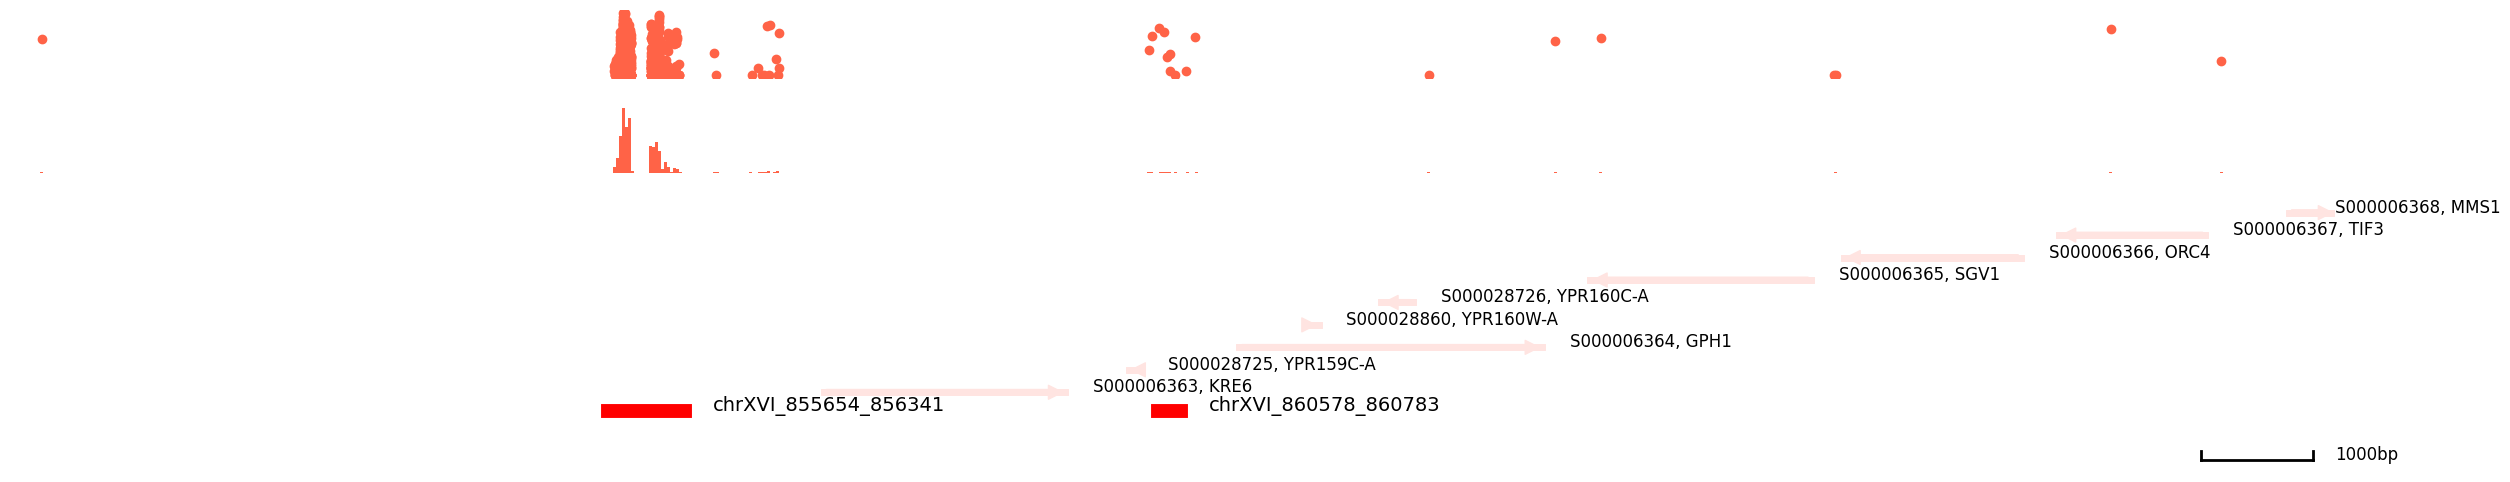

In [9]:
cc.pl.draw_area("chrXVI",860297,861116,10000,peak_data, qbed_data, "sacCer3", 
                figsize = (30,6),peak_line = 1,save = False,plotsize = [1,1,4], example_length = 1000)

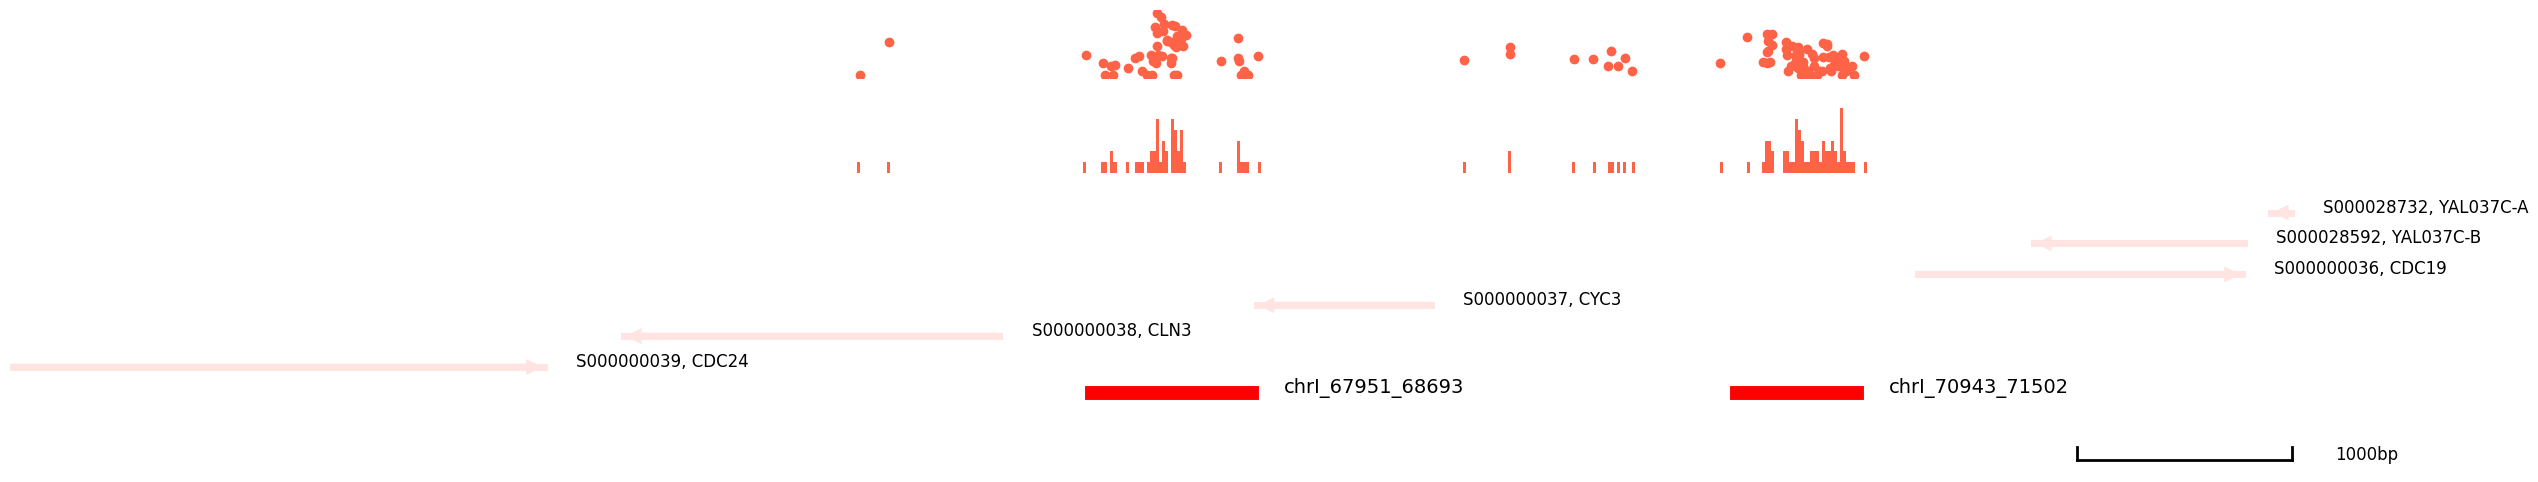

In [10]:
cc.pl.draw_area("chrI",68926,67722,6000,peak_data, qbed_data, "sacCer3", 
                figsize = (30,6),peak_line = 1,save = False,plotsize = [1,1,4], example_length = 1000)

We could also visualize our data in [WashU Epigenome Browser](http://epigenomegateway.wustl.edu/browser/) directly. 
Notice that this link only valid for 24h, please rerun it if you want to use it.

For bedgraph file, it is aimed to show the distribution of qbed data. Please set the the **Aggregate method** of bedgraph file to *count* or *sum*, and fix the *Y-axis* if you want to compare several data.

In [11]:
qbed= {"TYE7":TYE7, "TYE7_gcr2ko":TYE7_gcr2ko}
bed = {'PEAK':peak_data}
cc.pl.WashU_browser_url(qbed,bed,genome = 'sacCer3')

All qbed addressed
All bed addressed
Uploading files
Please click the following link to see the data on WashU Epigenome Browser directly.
https://epigenomegateway.wustl.edu/browser/?genome=sacCer3&hub=https://companion.epigenomegateway.org//task/911ed2e17eec3cf6cf977dbf53820b4d/output//datahub.json


We advise to look at the whole chromosome and see the distribution of peaks to make sure everything is going right.

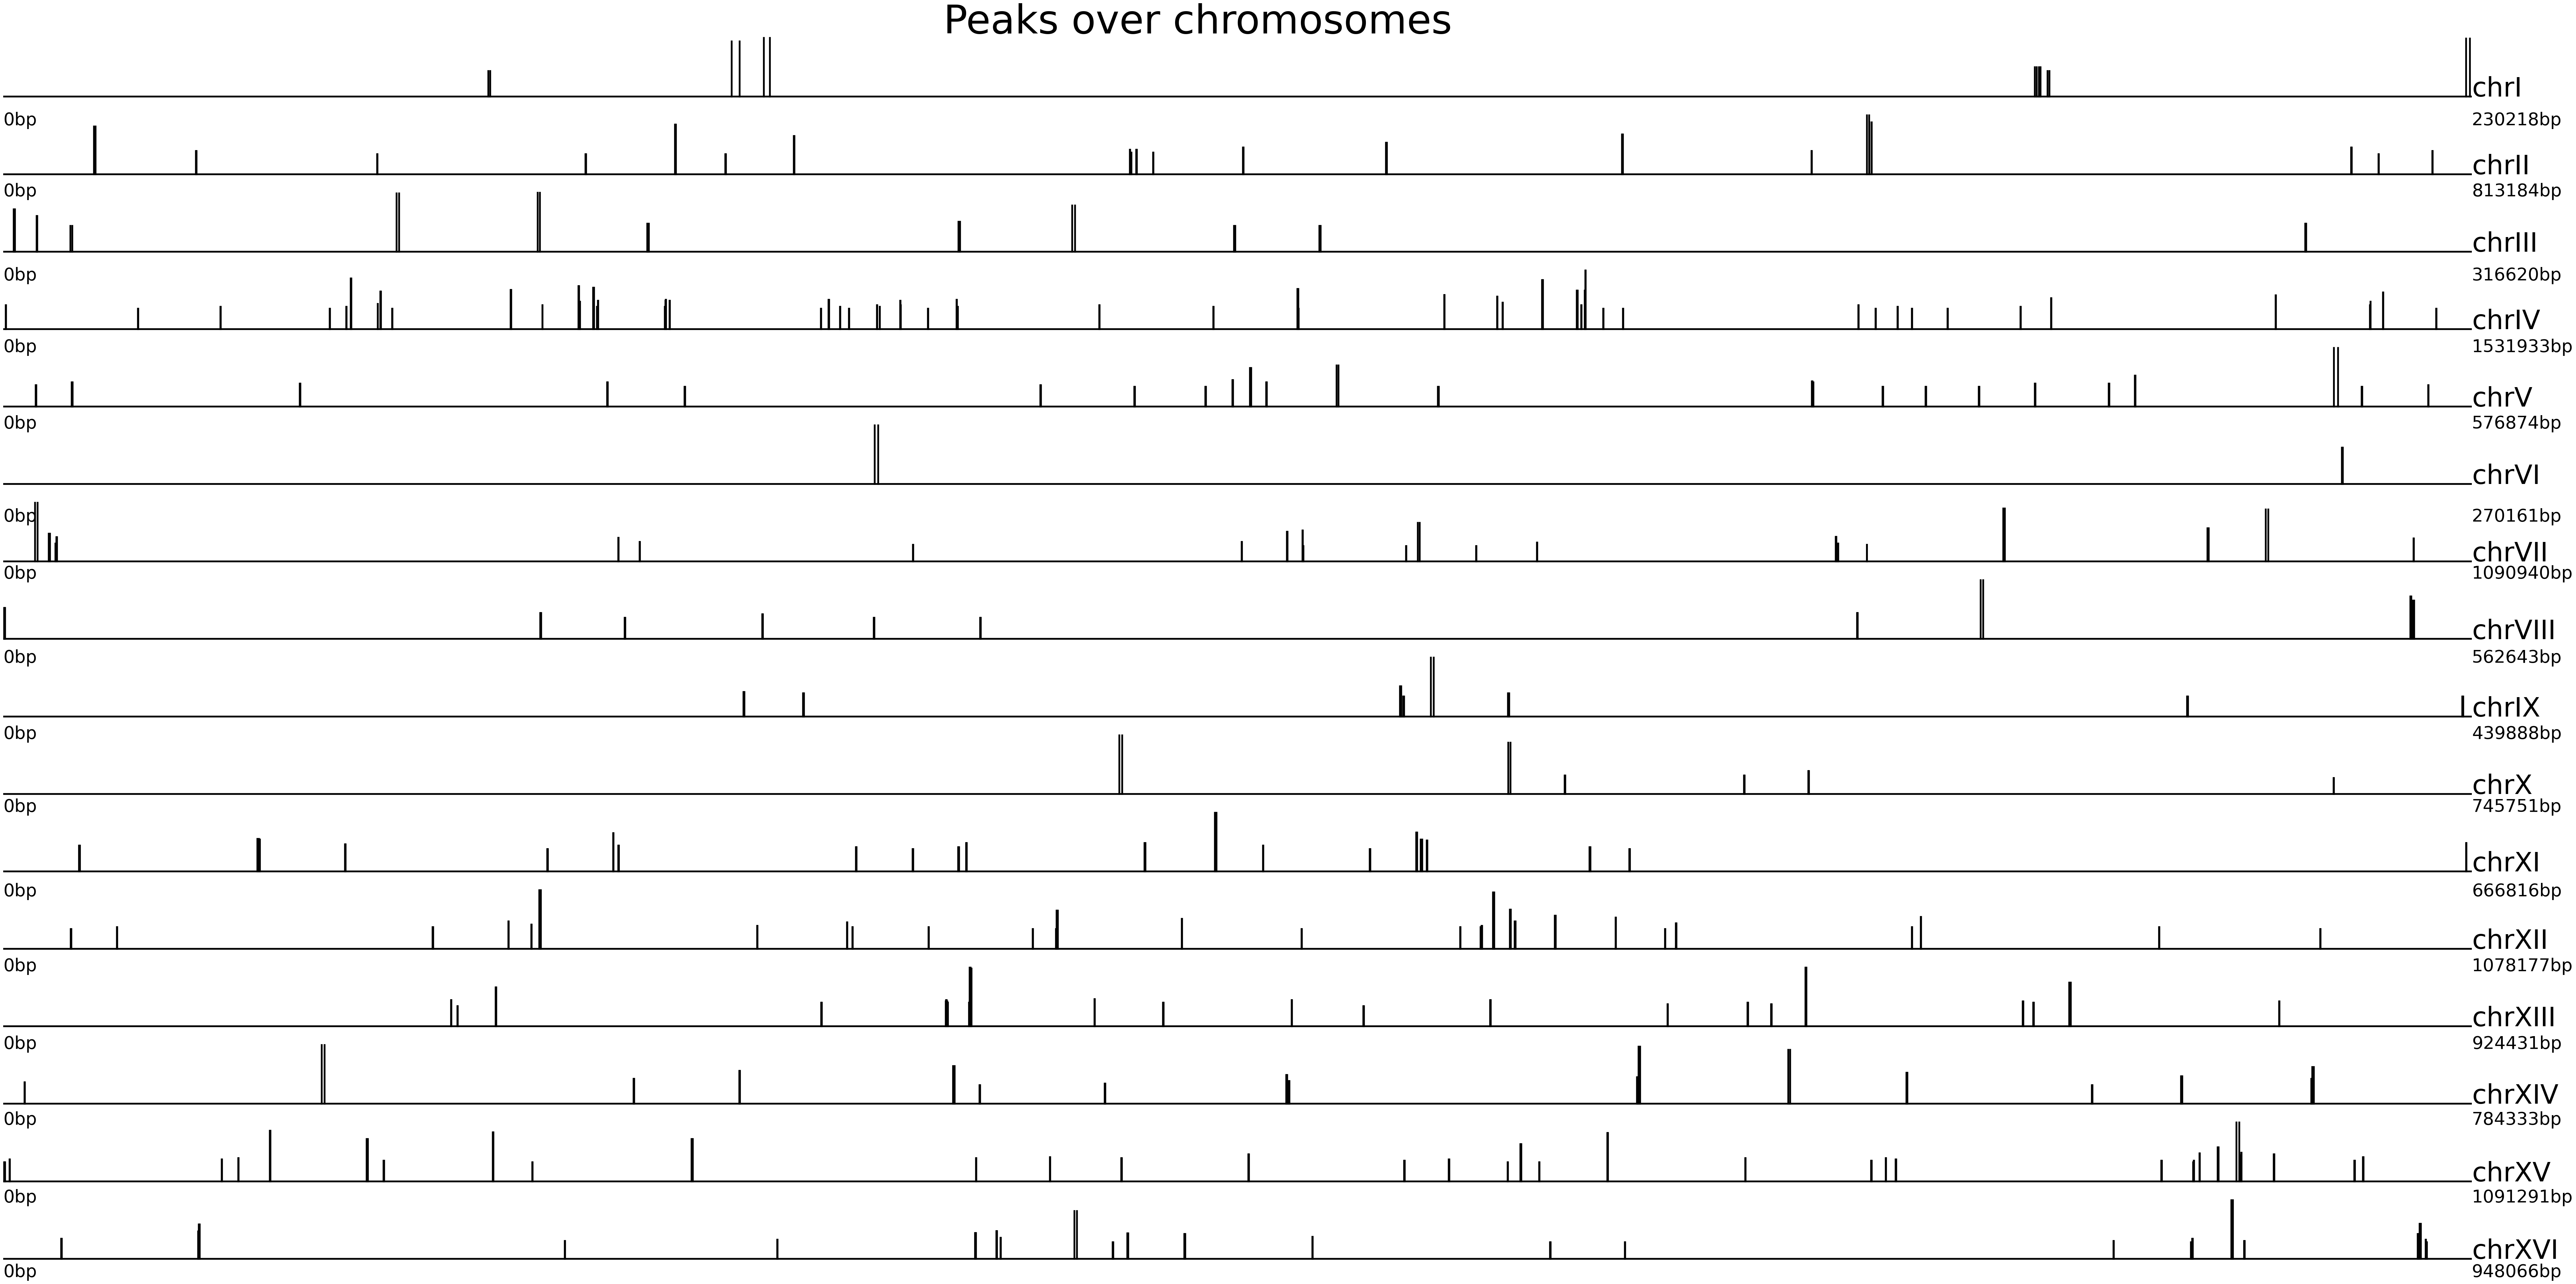

In [12]:
cc.pl.whole_peaks(peak_data, reference = 'sacCer3')

In the next step, we annotate the peaks by their closest genes using [bedtools](https://bedtools.readthedocs.io/en/latest/) and [pybedtools](https://daler.github.io/pybedtools/).
Make sure they are all previously installed before using.

In [13]:
peak_annotation = cc.pp.annotation(peak_data, reference = 'sacCer3')
peak_annotation = cc.pp.combine_annotation(peak_data,peak_annotation)
peak_annotation

In the bedtools method, we would use bedtools in the default path. Set bedtools path by 'bedtools_path' if needed.


,Chr,Start,End,Center,pvalue,Experiment Insertions,Reference Insertions,Fraction Experiment,TPH Experiment,Expect insertions,Nearest Refseq1,Gene Name1,Nearest Refseq2,Gene Name2
0,chrI,45252,45428,45354.0,6.764717e-02,5,11,0.000211,2105.883839,2.828763,S000000050,ACS1,S000000049,FLC2
1,chrI,67951,68693,68291.0,2.642331e-14,48,51,0.002022,20216.484859,13.115174,S000000037,CYC3,S000000038,CLN3
2,chrI,70943,71502,71275.0,0.000000e+00,61,45,0.002569,25691.782841,11.572212,S000000036,CDC19,S000028592,YAL037C-B
3,chrI,189451,189651,189576.0,3.775548e-10,7,0,0.000295,2948.237375,0.257160,S000000080,YAT1,S000000079,MST28
4,chrI,189841,189991,189928.0,2.047280e-04,7,6,0.000295,2948.237375,1.542962,S000000080,YAT1,S000000079,MST28
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
313,chrXVI,860578,860783,860688.0,9.089903e-04,6,5,0.000253,2527.060607,1.495148,S000028725,YPR159C-A,S000006364,GPH1
314,chrXVI,927289,927661,927481.0,4.053125e-02,14,30,0.000590,5896.474750,8.970891,S000006399,YPR195C,S000006398,OPT2
315,chrXVI,927958,928521,928300.5,5.686336e-08,45,62,0.001895,18952.954555,18.539841,S000006399,YPR195C,S000006398,OPT2
316,chrXVI,930350,930488,930413.5,1.216049e-09,7,0,0.000295,2948.237375,0.299030,S000006400,YPR196W,S000006399,YPR195C


Use qbed data, peak data and group names to make a group by peak anndata object.

In [14]:
adata_cc = cc.pp.makeAnndata(qbed_data, peak_annotation, ['TYE7', 'TYE7_gcr2ko'], key = 'group', reference = "sacCer3")
adata_cc

100%|██████████| 16/16 [00:00<00:00, 135.29it/s]


AnnData object with n_obs × n_vars = 2 × 318
    var: 'Chr', 'Start', 'End', 'Center', 'pvalue', 'Experiment Insertions', 'Reference Insertions', 'Fraction Experiment', 'TPH Experiment', 'Expect insertions', 'Nearest Refseq1', 'Gene Name1', 'Nearest Refseq2', 'Gene Name2'

Differential peak analysis would find out the significant binding for each group. In this example, we use *fisher exact test* to find out.

In [15]:
cc.tl.rank_peak_groups(adata_cc,"Index",method = 'fisher_exact',key_added = 'fisher_exact')

100%|██████████| 2/2 [00:05<00:00,  2.73s/it]


Plot the results for differential peak analysis.

Currently, the peaks are ranked by pvalues. It could also be ranked by logfoldchanges by the following codes:

```python
cc.tl.rank_peak_groups(adata_cc,"Index",method = 'fisher_exact',key_added = 'fisher_exact',rankby = 'logfoldchanges')
cc.pl.rank_peak_groups(adata_cc, key = 'fisher_exact',rankby = 'logfoldchanges')

```

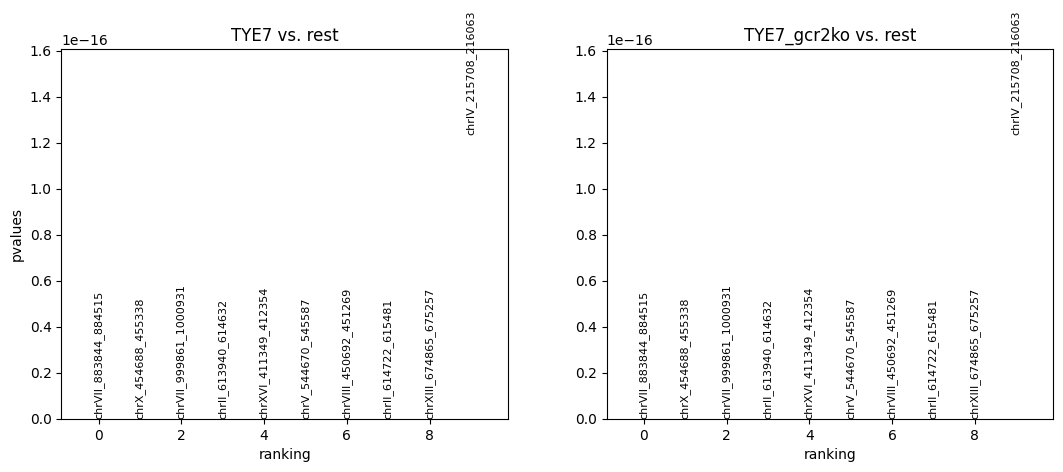

In [16]:
cc.pl.rank_peak_groups(adata_cc, key = 'fisher_exact')

Then, we take a look at the genome for highly differentiated peaks. The colored ones are the insertions for specific cluster and the grey ones are the total insertions information. If we input the backgound file, the grey ones would be the backgound insertions.

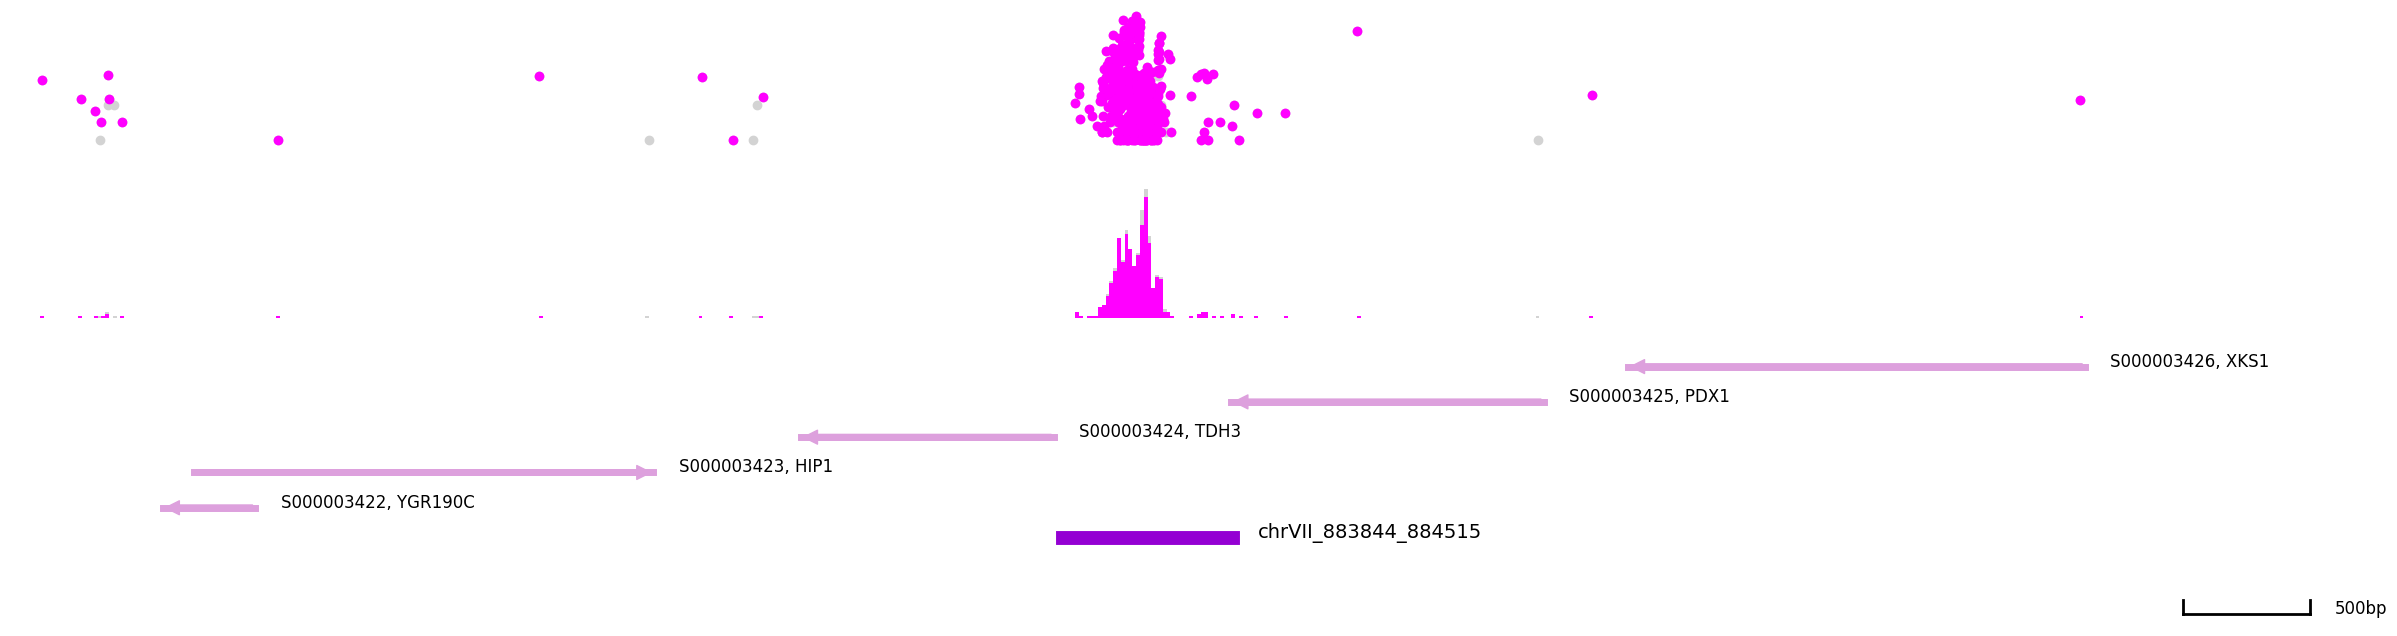

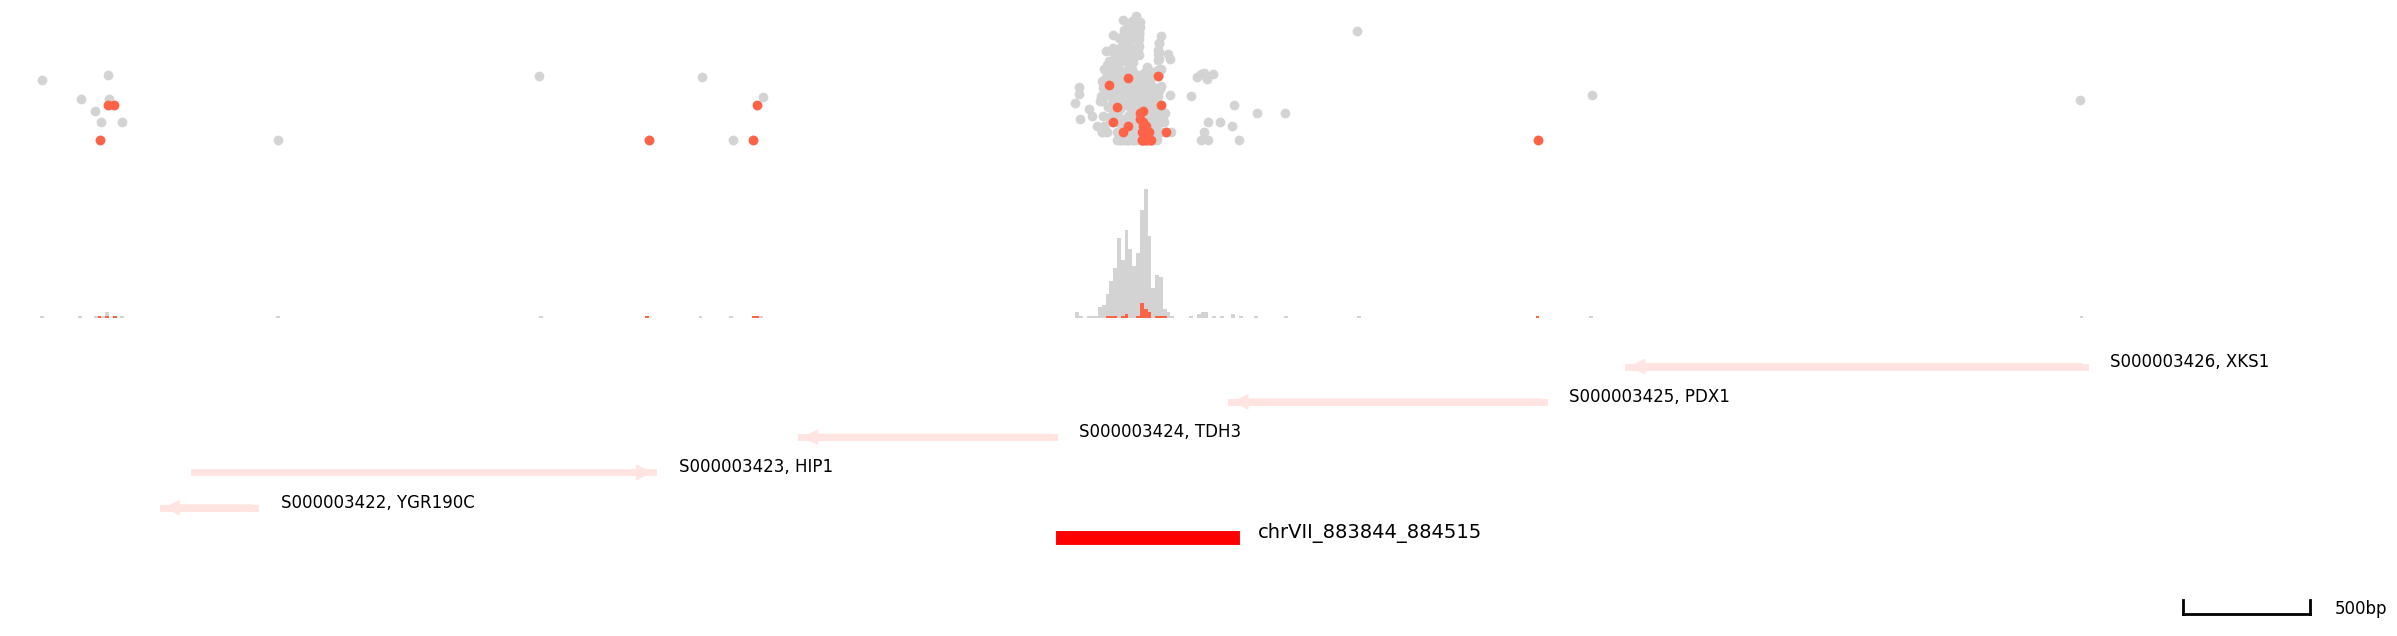

In [17]:
cc.pl.draw_area("chrVII",883694,884861, 4000, peak_data, qbed_data,"sacCer3",adata = adata_cc, 
                name = "TYE7",key = "Index",insertionkey = "group", figsize = (30,8),peak_line = 1, bins = 600, example_length=500,color = "purple")
cc.pl.draw_area("chrVII",883694,884861, 4000, peak_data, qbed_data,"sacCer3",adata = adata_cc, 
                name = "TYE7_gcr2ko",key = "Index", insertionkey = "group", figsize = (30,8),peak_line = 1,bins = 600,example_length=500)

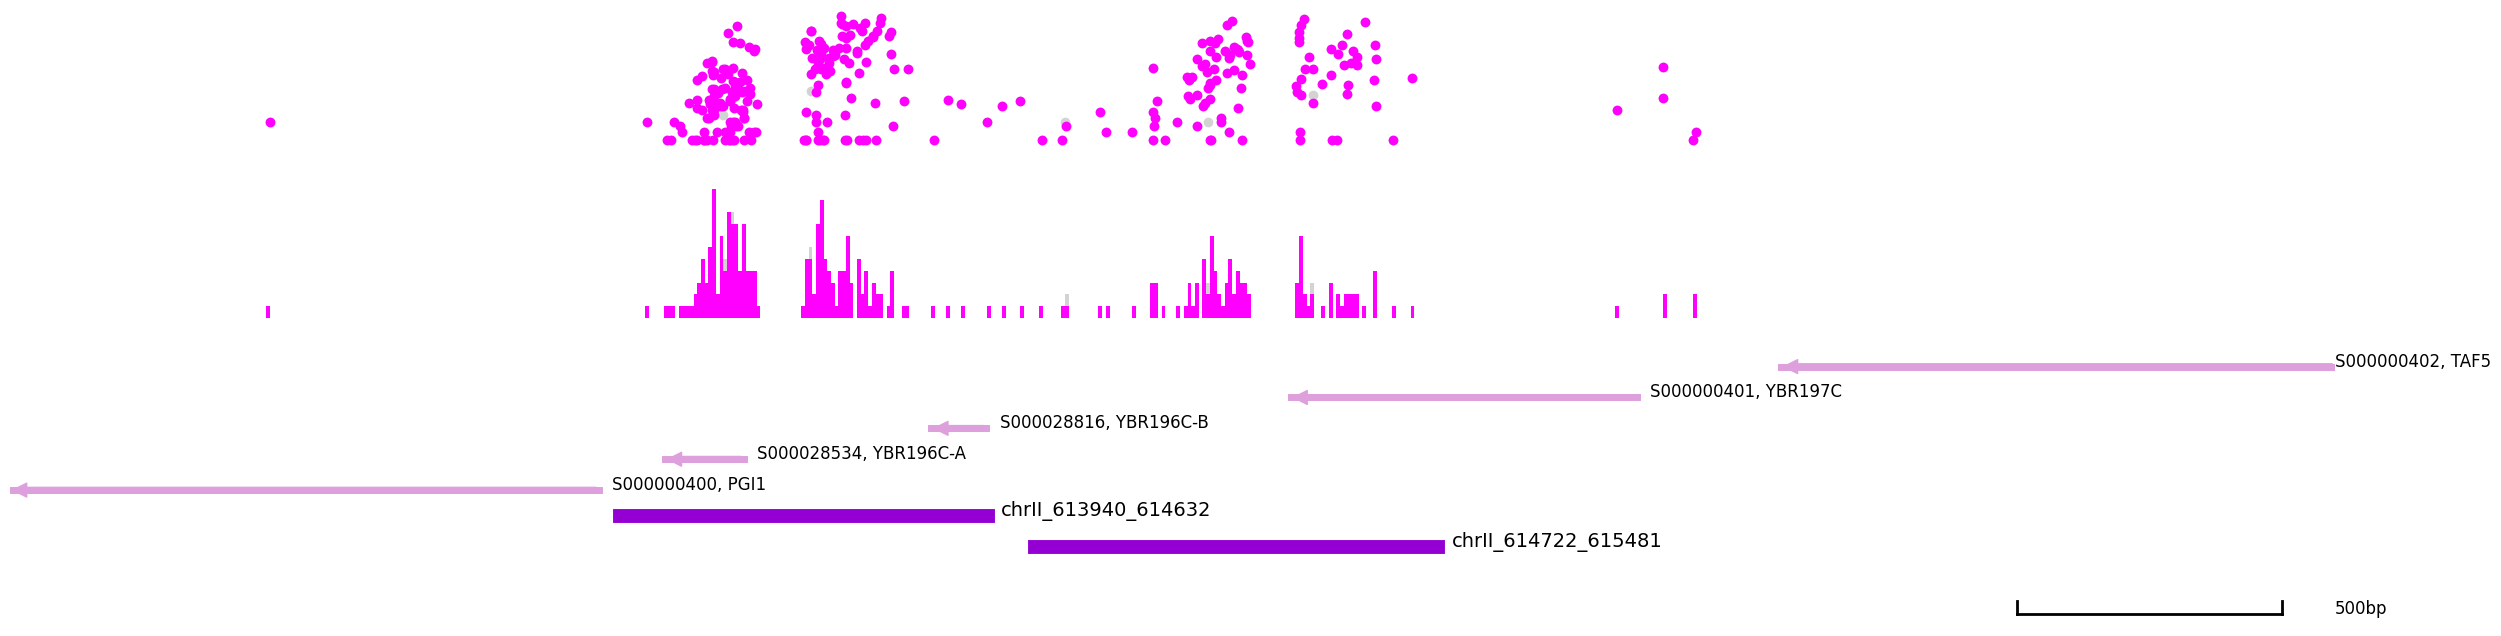

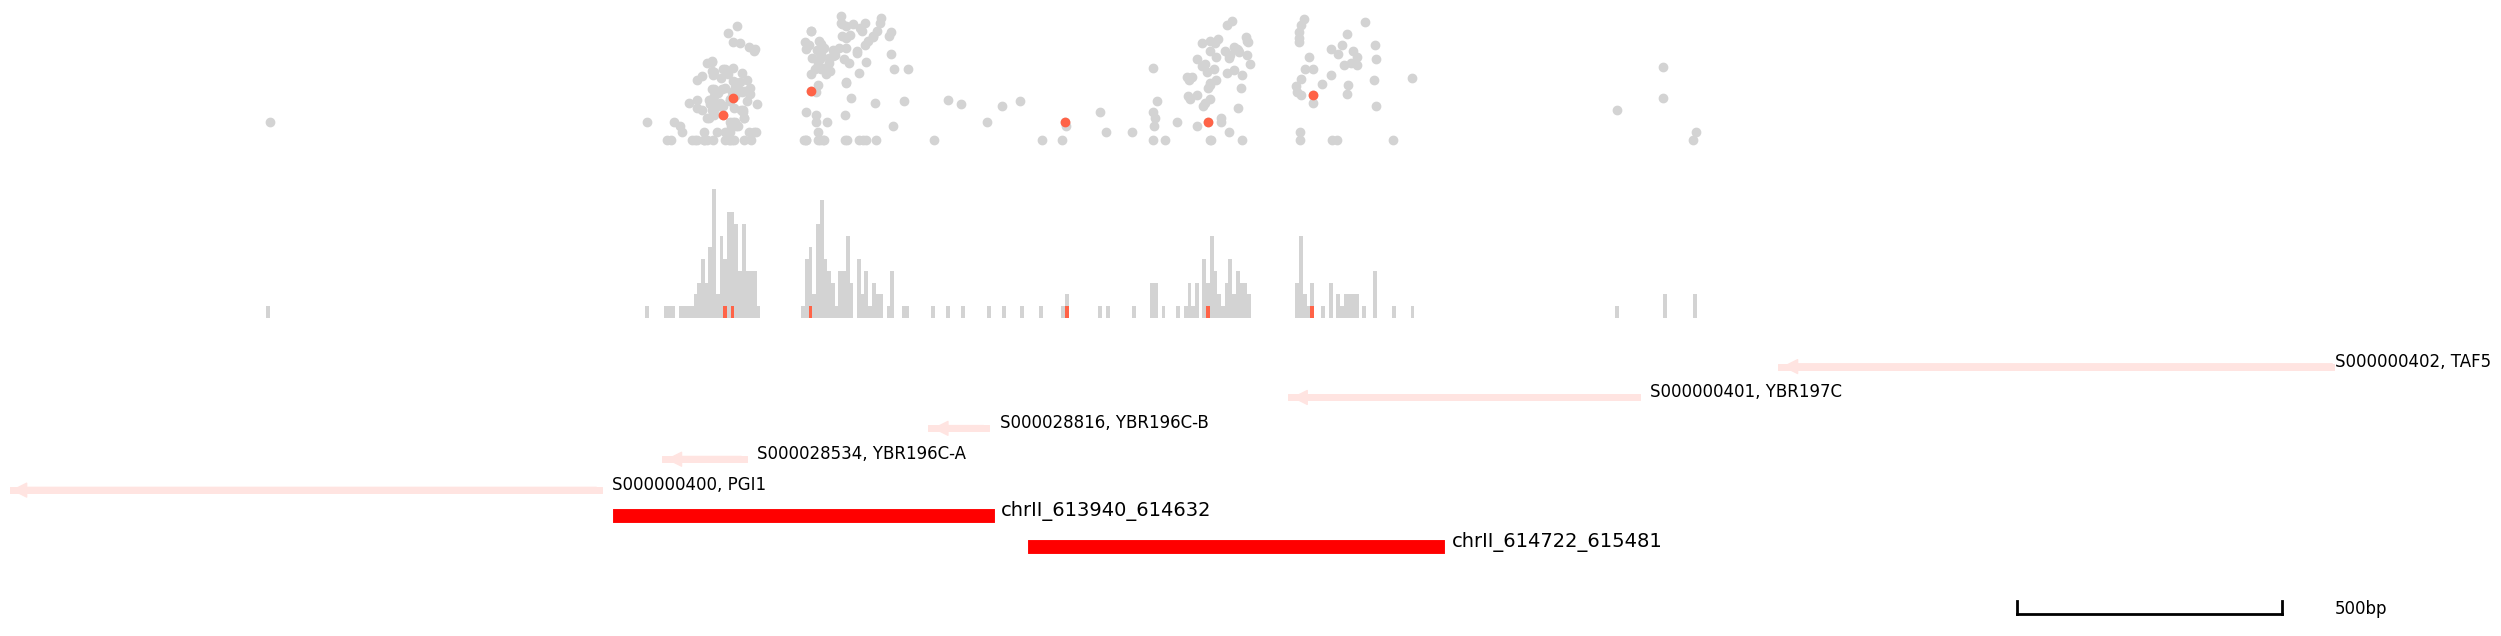

In [18]:
cc.pl.draw_area("chrII", 613790, 616171,1000, peak_data, qbed_data,"sacCer3",adata = adata_cc, 
                name = "TYE7",key = "Index",insertionkey = "group", figsize = (30,8),peak_line = 2, bins = 600, example_length=500,color = "purple")
cc.pl.draw_area("chrII", 613790, 616171,1000, peak_data, qbed_data,"sacCer3",adata = adata_cc, 
                name = "TYE7_gcr2ko",key = "Index", insertionkey = "group", figsize = (30,8),peak_line = 2,bins = 600,example_length=500)

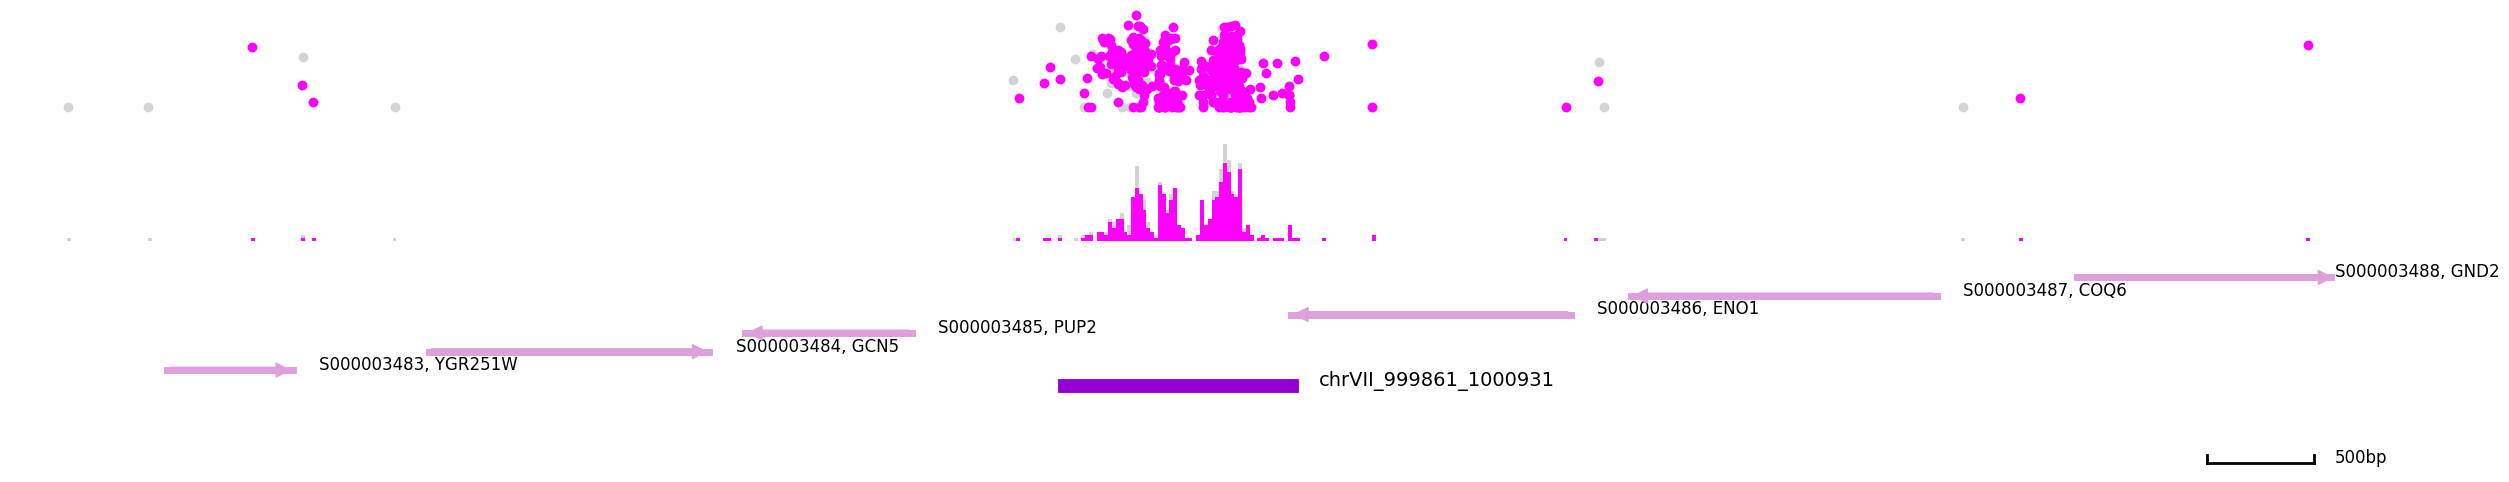

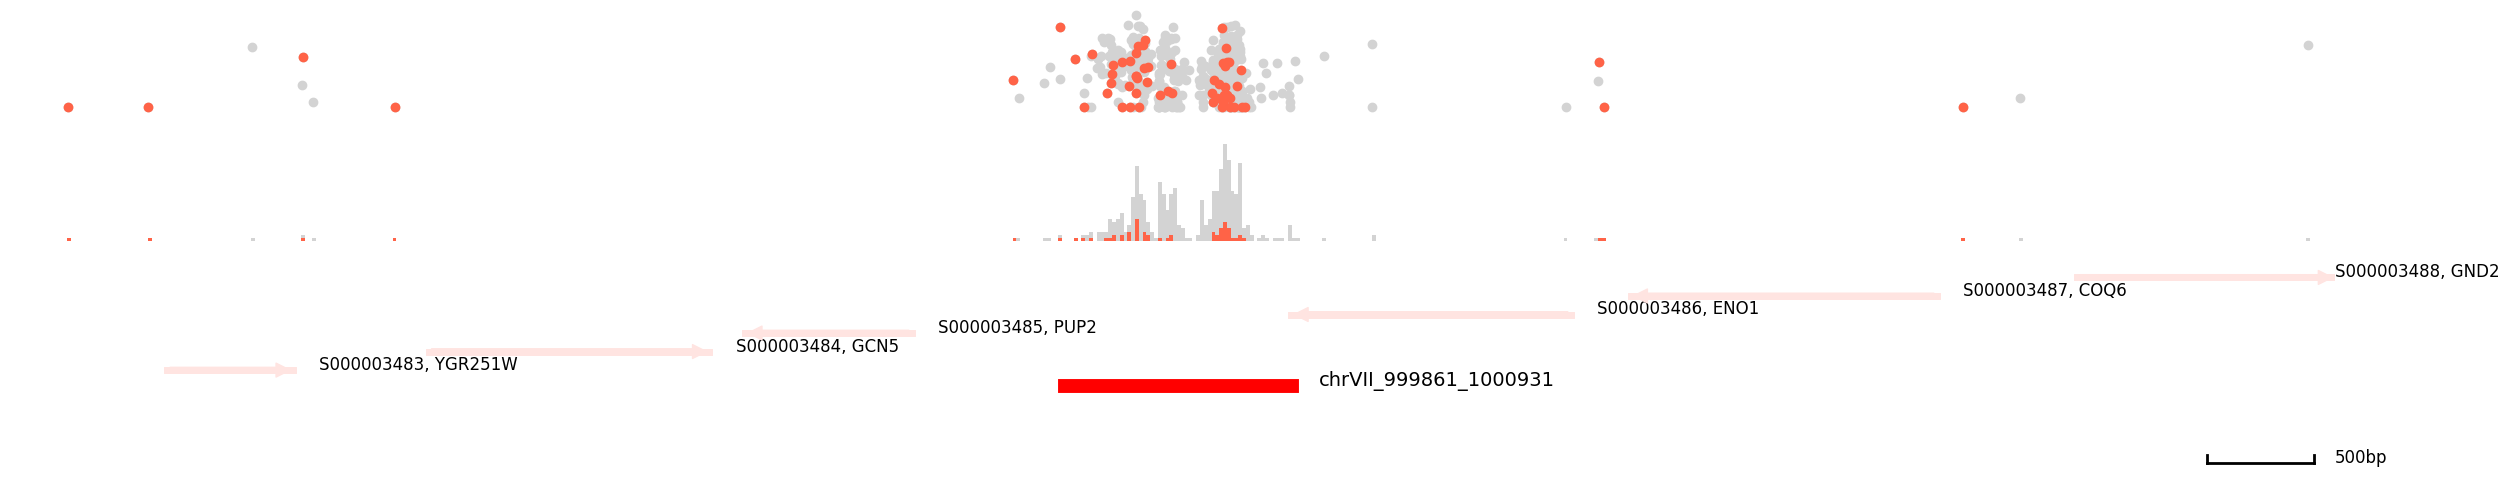

In [19]:
cc.pl.draw_area("chrVII", 999899, 1000836, 5000, peak_data, qbed_data,"sacCer3",adata = adata_cc, 
                name = "TYE7",key = "Index",insertionkey = "group", figsize = (30,6),peak_line = 3, bins = 600, example_length=500,color = "purple")
cc.pl.draw_area("chrVII", 999899, 1000836, 5000, peak_data, qbed_data,"sacCer3",adata = adata_cc, 
                name = "TYE7_gcr2ko",key = "Index", insertionkey = "group", figsize = (30,6),peak_line = 3,bins = 600,example_length=500)

Plot the volcano plot for differential binding sites.

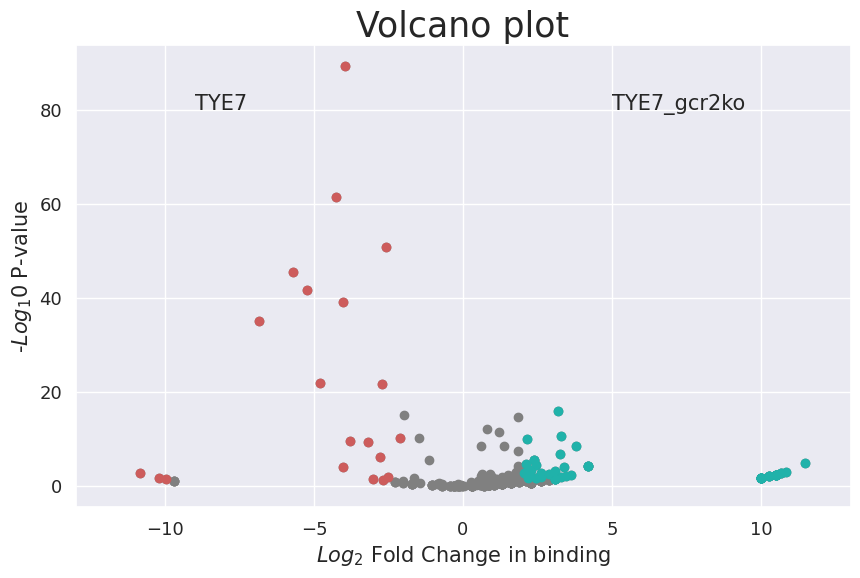

In [20]:
cc.pl.volcano_plot(adata_cc, pvalue_cutoff = 0.05, lfc_cutoff = 2,labelright = (5,80),labelleft = (-9,80))

This is the heatmap for relative calling cards bindings.

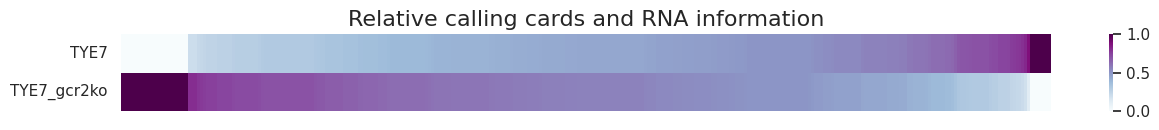

In [21]:
cc.pl.heatmap(adata_cc, figsize=(15,1))

In [22]:
adata_cc.var

,Chr,Start,End,Center,pvalue,Experiment Insertions,Reference Insertions,Fraction Experiment,TPH Experiment,Expect insertions,Nearest Refseq1,Gene Name1,Nearest Refseq2,Gene Name2
name,,,,,,,,,,,,,,
chrIII_122528_122714,chrIII,122528,122714,122623.0,4.274016e-02,7,17,0.000295,2948.237375,3.850752,S000000599,YCR006C,S000000598,CIT2
chrIII_1340_1530,chrIII,1340,1530,1430.5,1.558529e-07,18,19,0.000758,7581.181822,4.303782,S000000581,YCL076W,S000000575,YCL073C
chrIII_137107_137488,chrIII,137107,137488,137374.5,1.911649e-09,24,25,0.001011,10108.242429,5.662871,S000000604,ADP1,S000000605,PGK1
chrIII_157858_158018,chrIII,157858,158018,157965.0,5.790178e-03,5,7,0.000211,2105.883839,1.585604,S000000616,YCR022C,S000000617,YCR023C
chrIII_168825_168975,chrIII,168825,168975,168909.0,1.545608e-07,5,1,0.000211,2105.883839,0.226515,S000000622,RHB1,S000000623,FEN2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
chrX_454688_455338,chrX,454688,455338,454954.0,0.000000e+00,316,23,0.013309,133091.858653,9.574593,S000003769,TDH2,S000003771,MET3
chrX_471741_471936,chrX,471741,471936,471828.0,9.324881e-02,7,11,0.000295,2948.237375,4.579153,S000003786,BNA1,S000003785,MDE1
chrX_525871_526061,chrX,525871,526061,525940.0,3.745516e-02,7,9,0.000295,2948.237375,3.746580,S000003809,CYC1,S000003808,ANB1


In some cases, the peaks are divided in two and the gap mighe be acture binding sites. This often happens in yeast data because insertions could bind everywhere, but it rarely happens in human/mouse beacause it could only bind in TTAA sites.

So we could perform a footprint analysis on yeast data and see. 

In [23]:
adata_cc.var = cc.tl.footprint(adata_cc.var ,qbed_data)
adata_cc.var

,Chr,Start,End,Center,pvalue,Experiment Insertions,Reference Insertions,Fraction Experiment,TPH Experiment,Expect insertions,Nearest Refseq1,Gene Name1,Nearest Refseq2,Gene Name2,Chr_footprint,Start_footprint,End_footprint
name,,,,,,,,,,,,,,,,,
chrIII_122528_122714,chrIII,122528,122714,122623.0,4.274016e-02,7,17,0.000295,2948.237375,3.850752,S000000599,YCR006C,S000000598,CIT2,chrIII,122528,122714
chrIII_1340_1530,chrIII,1340,1530,1430.5,1.558529e-07,18,19,0.000758,7581.181822,4.303782,S000000581,YCL076W,S000000575,YCL073C,chrIII,1340,1530
chrIII_137107_137488,chrIII,137107,137488,137374.5,1.911649e-09,24,25,0.001011,10108.242429,5.662871,S000000604,ADP1,S000000605,PGK1,chrIII,137260,137371
chrIII_157858_158018,chrIII,157858,158018,157965.0,5.790178e-03,5,7,0.000211,2105.883839,1.585604,S000000616,YCR022C,S000000617,YCR023C,chrIII,157858,158018
chrIII_168825_168975,chrIII,168825,168975,168909.0,1.545608e-07,5,1,0.000211,2105.883839,0.226515,S000000622,RHB1,S000000623,FEN2,chrIII,168825,168975
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
chrX_454688_455338,chrX,454688,455338,454954.0,0.000000e+00,316,23,0.013309,133091.858653,9.574593,S000003769,TDH2,S000003771,MET3,chrX,454688,455338
chrX_471741_471936,chrX,471741,471936,471828.0,9.324881e-02,7,11,0.000295,2948.237375,4.579153,S000003786,BNA1,S000003785,MDE1,chrX,471741,471936
chrX_525871_526061,chrX,525871,526061,525940.0,3.745516e-02,7,9,0.000295,2948.237375,3.746580,S000003809,CYC1,S000003808,ANB1,chrX,525871,526061


Above is the footprint data saved in adata_cc. Here we do it again and perserve in bed data.

In [24]:
footprint_bed = cc.tl.footprint(peak_data,qbed_data,return_bed = True,delete_unfound = True)
footprint_bed[0:10]

/scratch/rmlab/rmlab_shared/g.juanru/pycallingcards/pycallingcards/pycallingcards/tools/_footprint.py:103: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  result.iloc[:,1:3] = result.iloc[:,1:3].astype(int)


,Chr_footprint,Start_footprint,End_footprint
1,chrI,68315,68635
2,chrI,71257,71384
6,chrI,229810,229909
7,chrII,30162,30396
11,chrII,221486,221549
20,chrII,533381,533472
22,chrII,614152,614329
23,chrII,615100,615264
30,chrIII,50533,50620
31,chrIII,68641,68728


Let's visulize part of the footprint points.

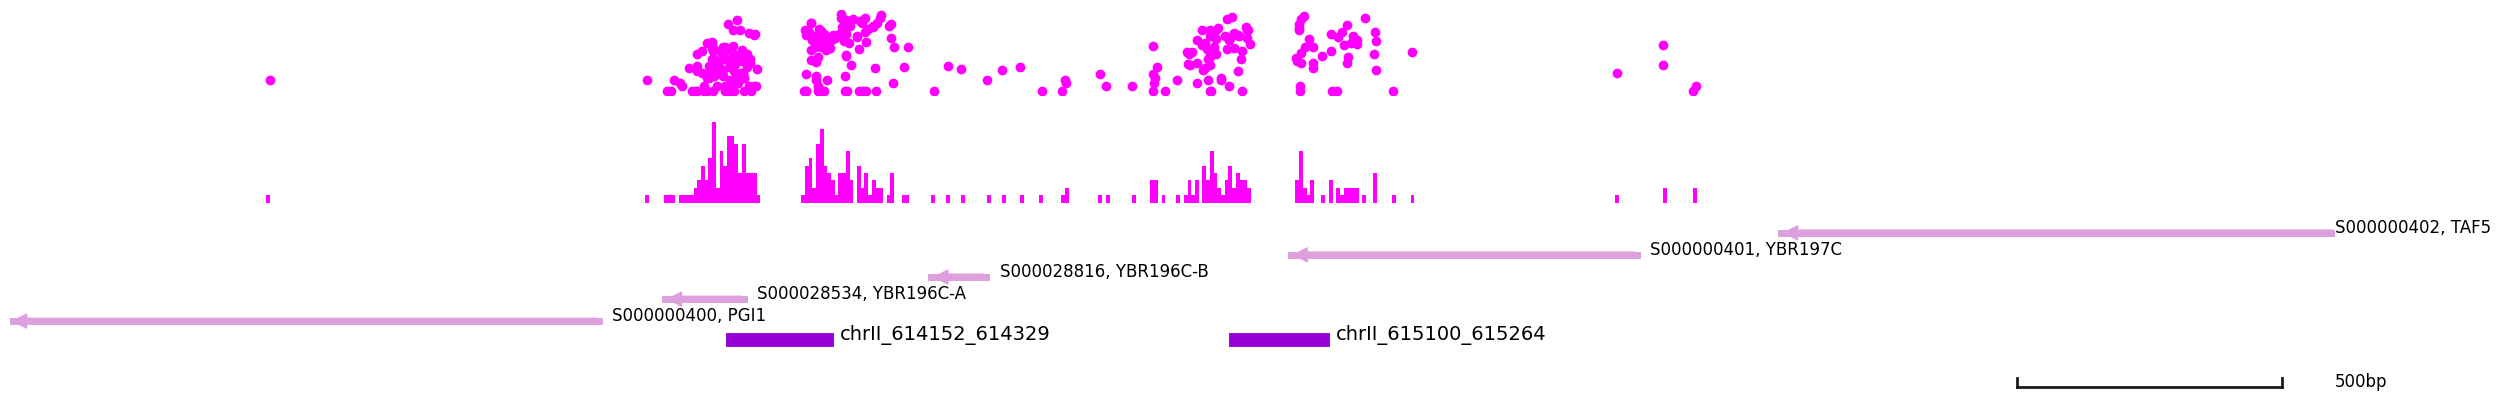

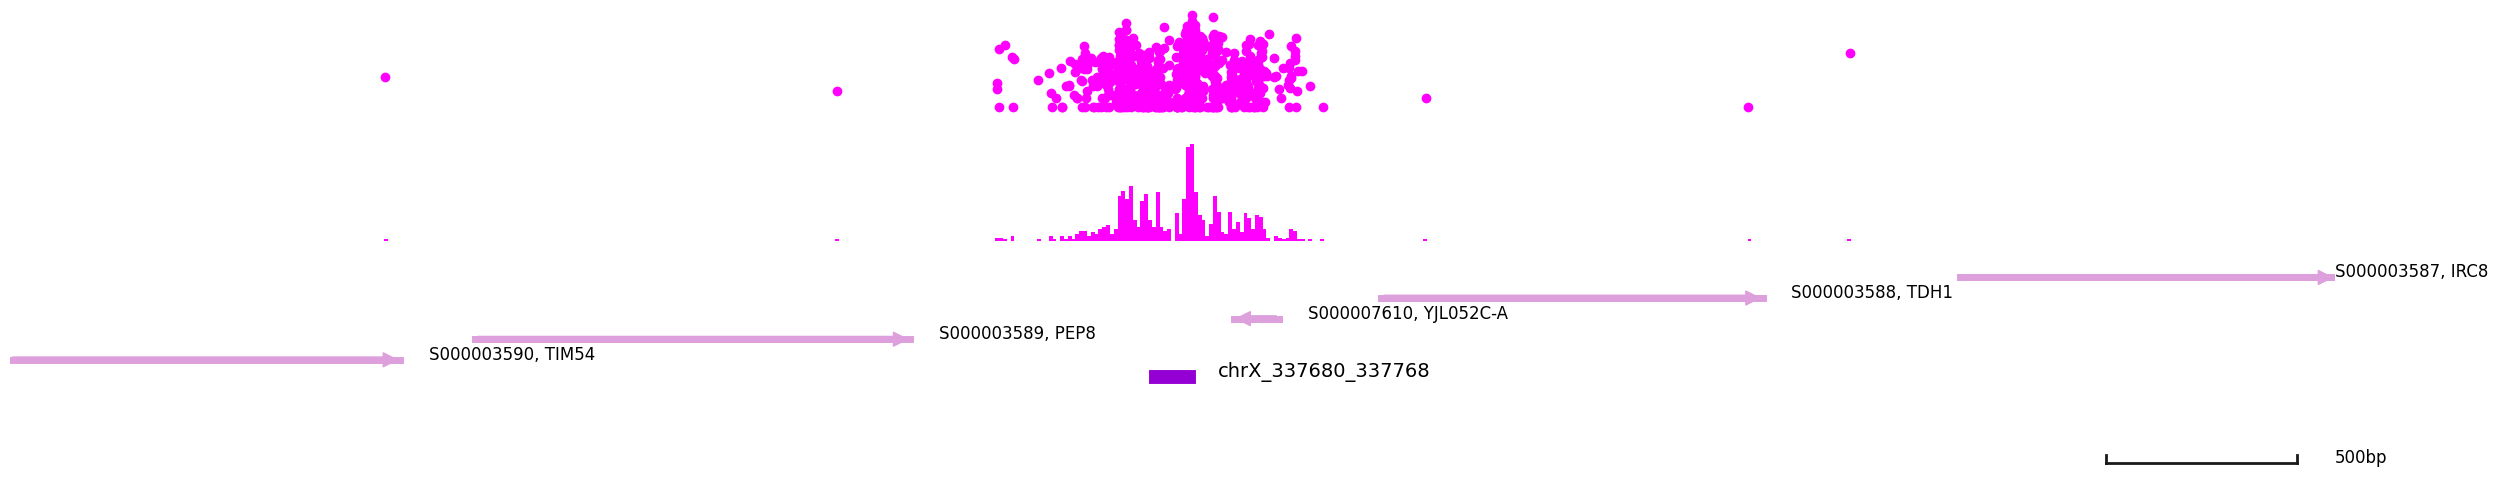

In [32]:
cc.pl.draw_area("chrII", 613790, 616171,1000, footprint_bed, qbed_data,"sacCer3",
                key = "Index",insertionkey = "group", figsize = (30,5),peak_line = 1, bins = 600, example_length=500,color = "purple")
cc.pl.draw_area("chrX",337680, 337768, 3000, footprint_bed, qbed_data,"sacCer3",
                key = "Index",insertionkey = "group", figsize = (30,6),peak_line = 3, bins = 600, example_length=500,color = "purple")

Saved the file if needed.

In [26]:
adata_cc.write("yeast.h5ad")